Diminos Case Study

##### Problem statement

Diminos has mandated that all franchise stores must meet a service-level agreement where the 95th percentile of order delivery time should be under 31 minutes. Failure to meet this metric may result in loss of franchise rights.

Kanav, who operates a Diminos store on a 24×7 basis, wants to evaluate whether his store currently meets this requirement and identify performance risks that could impact compliance. The objective of this analysis is to perform Exploratory Data Analysis (EDA) on historical order data to assess delivery performance, detect potential bottlenecks, and provide actionable insights to help Kanav protect and grow his business.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

df = pd.read_csv('diminos_data.csv')

print("First 5 rows of the DataFrame:")
print(df.head())

print("\nLast 5 rows of the DataFrame:")
print(df.tail())

First 5 rows of the DataFrame:
   order_id      order_placed_at          order_delivered_at
0   1523111  2023-03-01 00:00:59  2023-03-01 00:18:07.443132
1   1523112  2023-03-01 00:03:59  2023-03-01 00:19:34.925241
2   1523113  2023-03-01 00:07:22  2023-03-01 00:22:28.291385
3   1523114  2023-03-01 00:07:47  2023-03-01 00:46:19.019399
4   1523115  2023-03-01 00:09:03  2023-03-01 00:25:13.619056

Last 5 rows of the DataFrame:
       order_id      order_placed_at          order_delivered_at
14995   1538106  2023-03-27 23:37:05  2023-03-27 23:52:37.409378
14996   1538107  2023-03-27 23:47:38  2023-03-28 00:04:22.672912
14997   1538108  2023-03-27 23:50:16  2023-03-28 00:05:40.676238
14998   1538109  2023-03-27 23:52:44  2023-03-28 00:08:41.810358
14999   1538110  2023-03-27 23:58:20  2023-03-28 00:13:42.499311


In [40]:
print("DataFrame Shape:", df.shape)
print("\nColumn Names:", df.columns.tolist())
print("\nColumn Data Types:\n", df.dtypes)

DataFrame Shape: (15000, 3)

Column Names: ['order_id', 'order_placed_at', 'order_delivered_at']

Column Data Types:
 order_id               int64
order_placed_at       object
order_delivered_at    object
dtype: object


In [41]:
column_classification = [
    {'Column Name': 'order_id', 'Data Type': 'Integer', 'Description': 'Unique identifier for each order.'},
    {'Column Name': 'order_placed_at', 'Data Type': 'Object (string)', 'Description': 'Timestamp indicating when the order was placed.'},
    {'Column Name': 'order_delivered_at', 'Data Type': 'Object (string)', 'Description': 'Timestamp indicating when the order was delivered.'}
]

column_classification_df = pd.DataFrame(column_classification)

print("\nColumn Classification Table:")
print(column_classification_df.to_markdown(index=False))

print("\nDescriptive Statistics for 'order_id' (Numerical Identifier):")
print(df['order_id'].describe().to_markdown())


Column Classification Table:
| Column Name        | Data Type       | Description                                        |
|:-------------------|:----------------|:---------------------------------------------------|
| order_id           | Integer         | Unique identifier for each order.                  |
| order_placed_at    | Object (string) | Timestamp indicating when the order was placed.    |
| order_delivered_at | Object (string) | Timestamp indicating when the order was delivered. |

Descriptive Statistics for 'order_id' (Numerical Identifier):
|       |        order_id |
|:------|----------------:|
| count | 15000           |
| mean  |     1.53061e+06 |
| std   |  4330.27        |
| min   |     1.52311e+06 |
| 25%   |     1.52686e+06 |
| 50%   |     1.53061e+06 |
| 75%   |     1.53436e+06 |
| max   |     1.53811e+06 |


In [42]:
df['order_placed_at'] = pd.to_datetime(df['order_placed_at'])
df['order_delivered_at'] = pd.to_datetime(df['order_delivered_at'])

df['delivery_duration'] = (df['order_delivered_at'] - df['order_placed_at']).dt.total_seconds() / 60

print("\nDescriptive Statistics for 'delivery_duration' (in minutes):")
print(df['delivery_duration'].describe().to_markdown())


Descriptive Statistics for 'delivery_duration' (in minutes):
|       |   delivery_duration |
|:------|--------------------:|
| count |          15000      |
| mean  |             20.4994 |
| std   |             96.1604 |
| min   |             15      |
| 25%   |             15.2748 |
| 50%   |             15.798  |
| 75%   |             17.2797 |
| max   |           7299.83   |


In [43]:
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_info = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage (%)': missing_percentage
})

print("Missing Value Information:")
print(missing_info.to_markdown())

Missing Value Information:
|                    |   Missing Count |   Missing Percentage (%) |
|:-------------------|----------------:|-------------------------:|
| order_id           |               0 |                        0 |
| order_placed_at    |               0 |                        0 |
| order_delivered_at |               0 |                        0 |
| delivery_duration  |               0 |                        0 |


In [45]:
df.drop_duplicates(inplace=True)
print(f"Number of rows after removing duplicates: {len(df)}")

# Although no missing values were found, this is a standard cleaning step.
df.dropna(inplace=True)
print(f"Number of rows after handling missing values: {len(df)}")

# Cap outliers in 'delivery_duration' using the previously calculated IQR bounds
df['delivery_duration'] = np.where(df['delivery_duration'] < lower_bound, lower_bound, df['delivery_duration'])
df['delivery_duration'] = np.where(df['delivery_duration'] > upper_bound, upper_bound, df['delivery_duration'])

print(f"'delivery_duration' column capped using IQR method. Min value: {df['delivery_duration'].min():.2f}, Max value: {df['delivery_duration'].max():.2f}")

Number of rows after removing duplicates: 15000
Number of rows after handling missing values: 15000
'delivery_duration' column capped using IQR method. Min value: 15.00, Max value: 20.29


In [46]:
df['delivery_duration_uncapped'] = (df['order_delivered_at'] - df['order_placed_at']).dt.total_seconds() / 60
df['order_hour'] = df['order_placed_at'].dt.hour
df['day_of_week'] = df['order_placed_at'].dt.day_name()
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday'])

sla_threshold = 31 # minutes
df['is_sla_breach'] = df['delivery_duration'] > sla_threshold

print("New features created: 'delivery_duration_uncapped', 'order_hour', 'day_of_week', 'is_weekend', 'is_sla_breach'.")
print("First 5 rows with new features:")
print(df[['order_placed_at', 'order_delivered_at', 'delivery_duration_uncapped', 'delivery_duration', 'order_hour', 'day_of_week', 'is_weekend', 'is_sla_breach']].head().to_markdown(index=False))

New features created: 'delivery_duration_uncapped', 'order_hour', 'day_of_week', 'is_weekend', 'is_sla_breach'.
First 5 rows with new features:
| order_placed_at     | order_delivered_at         |   delivery_duration_uncapped |   delivery_duration |   order_hour | day_of_week   | is_weekend   | is_sla_breach   |
|:--------------------|:---------------------------|-----------------------------:|--------------------:|-------------:|:--------------|:-------------|:----------------|
| 2023-03-01 00:00:59 | 2023-03-01 00:18:07.443132 |                      17.1407 |             17.1407 |            0 | Wednesday     | False        | False           |
| 2023-03-01 00:03:59 | 2023-03-01 00:19:34.925241 |                      15.5988 |             15.5988 |            0 | Wednesday     | False        | False           |
| 2023-03-01 00:07:22 | 2023-03-01 00:22:28.291385 |                      15.1049 |             15.1049 |            0 | Wednesday     | False        | False           |
| 2023

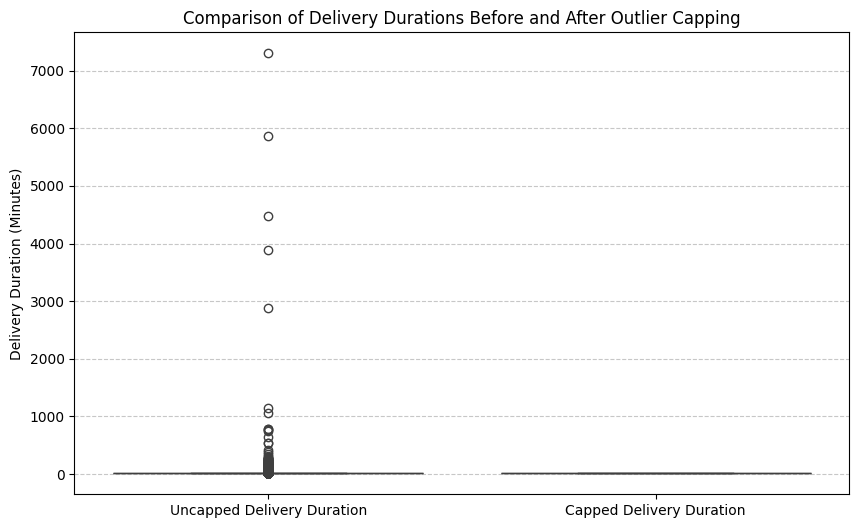

In [47]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['delivery_duration_uncapped', 'delivery_duration']])
plt.title('Comparison of Delivery Durations Before and After Outlier Capping')
plt.ylabel('Delivery Duration (Minutes)')
plt.xticks(ticks=[0, 1], labels=['Uncapped Delivery Duration', 'Capped Delivery Duration'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [48]:
mean_delivery_duration = df['delivery_duration'].mean()
median_delivery_duration = df['delivery_duration'].median()
percentile_95_delivery_duration = df['delivery_duration'].quantile(0.95)

# Recalculate SLA breach percentage based on the cleaned data if needed, or use existing 'is_sla_breach' column
# Note: The 'is_sla_breach' was calculated based on the capped delivery duration
overall_sla_breach_percentage = (df['is_sla_breach'].sum() / len(df)) * 100

print(f"Average Delivery Time: {mean_delivery_duration:.2f} minutes")
print(f"Median Delivery Time: {median_delivery_duration:.2f} minutes")
print(f"95th Percentile Delivery Time: {percentile_95_delivery_duration:.2f} minutes")
print(f"Overall SLA Breach Percentage: {overall_sla_breach_percentage:.2f}%")

Average Delivery Time: 16.57 minutes
Median Delivery Time: 15.80 minutes
95th Percentile Delivery Time: 20.29 minutes
Overall SLA Breach Percentage: 0.00%


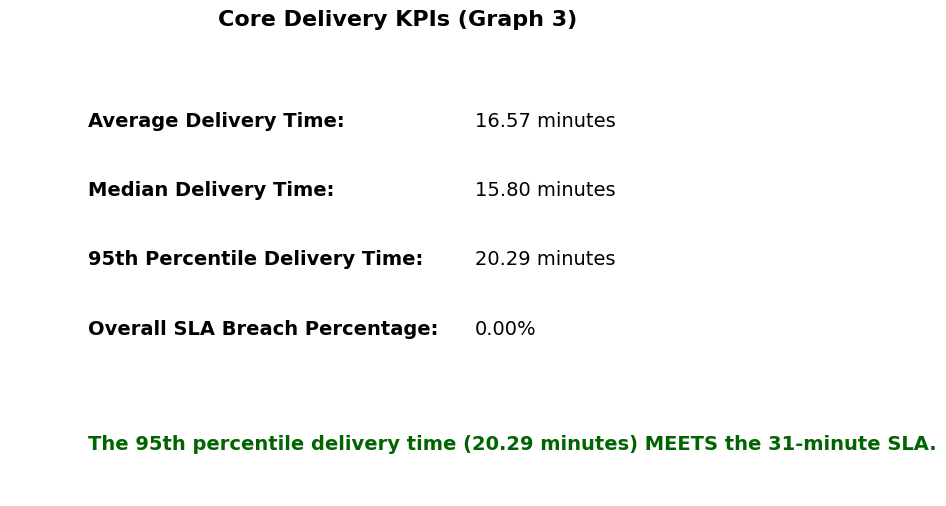

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))

# Hide axes
ax.axis('off')

# Define KPI positions and values
kpis = {
    "Average Delivery Time:": f"{mean_delivery_duration:.2f} minutes",
    "Median Delivery Time:": f"{median_delivery_duration:.2f} minutes",
    "95th Percentile Delivery Time:": f"{percentile_95_delivery_duration:.2f} minutes",
    "Overall SLA Breach Percentage:": f"{overall_sla_breach_percentage:.2f}%"
}

# Display KPIs in a tile-like format
y_pos = 0.8
for label, value in kpis.items():
    ax.text(0.1, y_pos, label, fontsize=14, weight='bold', transform=ax.transAxes)
    ax.text(0.6, y_pos, value, fontsize=14, transform=ax.transAxes)
    y_pos -= 0.15

# SLA statement
sla_met_statement = f"The 95th percentile delivery time ({percentile_95_delivery_duration:.2f} minutes) "
if percentile_95_delivery_duration <= sla_threshold:
    sla_met_statement += f"MEETS the {sla_threshold}-minute SLA."
else:
    sla_met_statement += f"DOES NOT MEET the {sla_threshold}-minute SLA."

ax.text(0.1, y_pos - 0.1, sla_met_statement, fontsize=14, color='darkgreen' if percentile_95_delivery_duration <= sla_threshold else 'red', weight='bold', transform=ax.transAxes)

plt.title('Core Delivery KPIs (Graph 3)', fontsize=16, weight='bold')
plt.show()

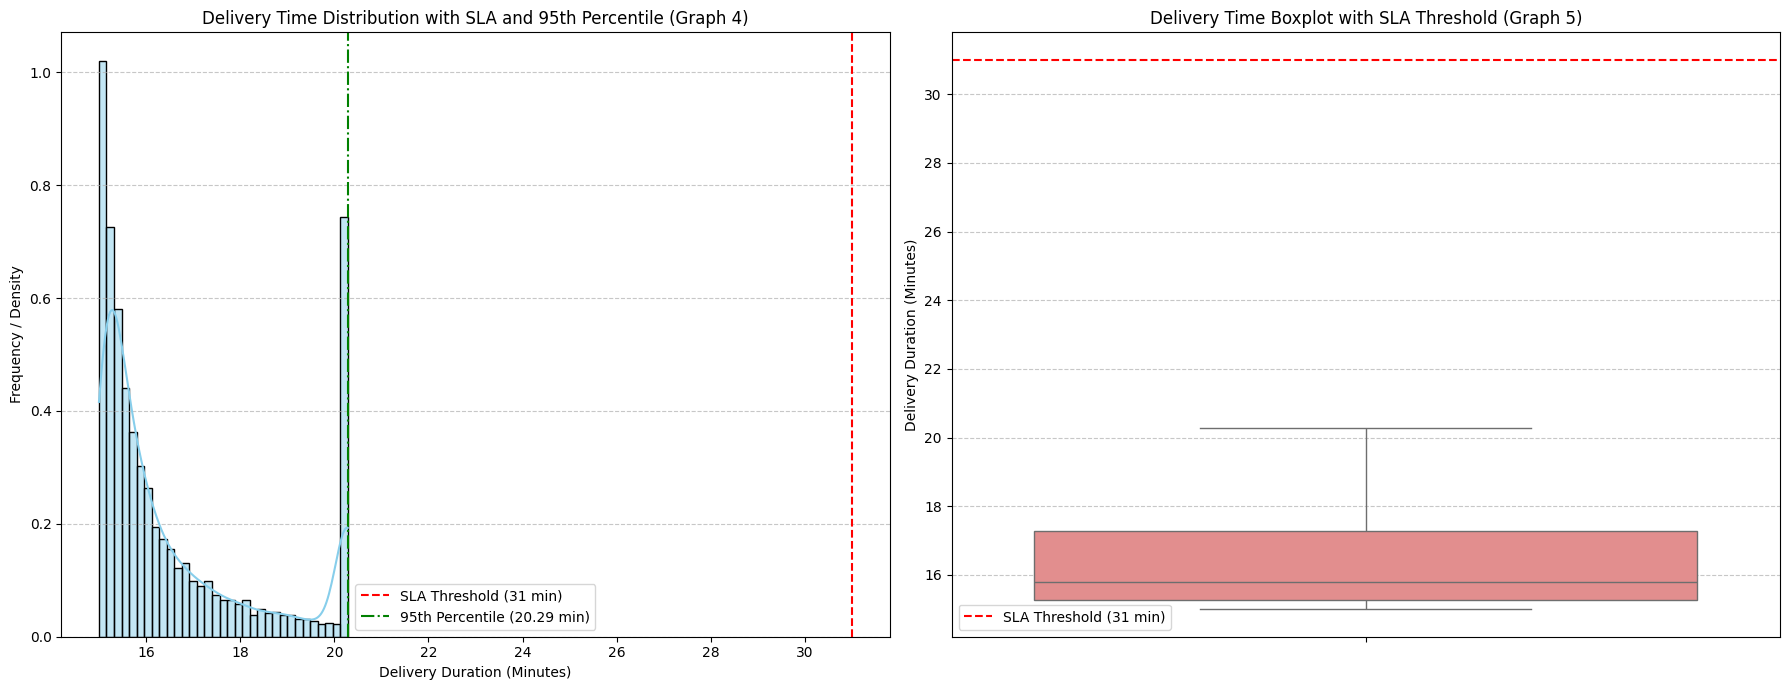

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Histogram with KDE
sns.histplot(df['delivery_duration'], kde=True, ax=axes[0], color='skyblue', stat='density')
axes[0].axvline(x=sla_threshold, color='r', linestyle='--', label=f'SLA Threshold ({sla_threshold} min)')
axes[0].axvline(x=percentile_95_delivery_duration, color='g', linestyle='-.', label=f'95th Percentile ({percentile_95_delivery_duration:.2f} min)')
axes[0].set_title('Delivery Time Distribution with SLA and 95th Percentile (Graph 4)')
axes[0].set_xlabel('Delivery Duration (Minutes)')
axes[0].set_ylabel('Frequency / Density')
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Boxplot
sns.boxplot(y=df['delivery_duration'], ax=axes[1], color='lightcoral')
axes[1].axhline(y=sla_threshold, color='r', linestyle='--', label=f'SLA Threshold ({sla_threshold} min)')
axes[1].set_title('Delivery Time Boxplot with SLA Threshold (Graph 5)')
axes[1].set_ylabel('Delivery Duration (Minutes)')
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

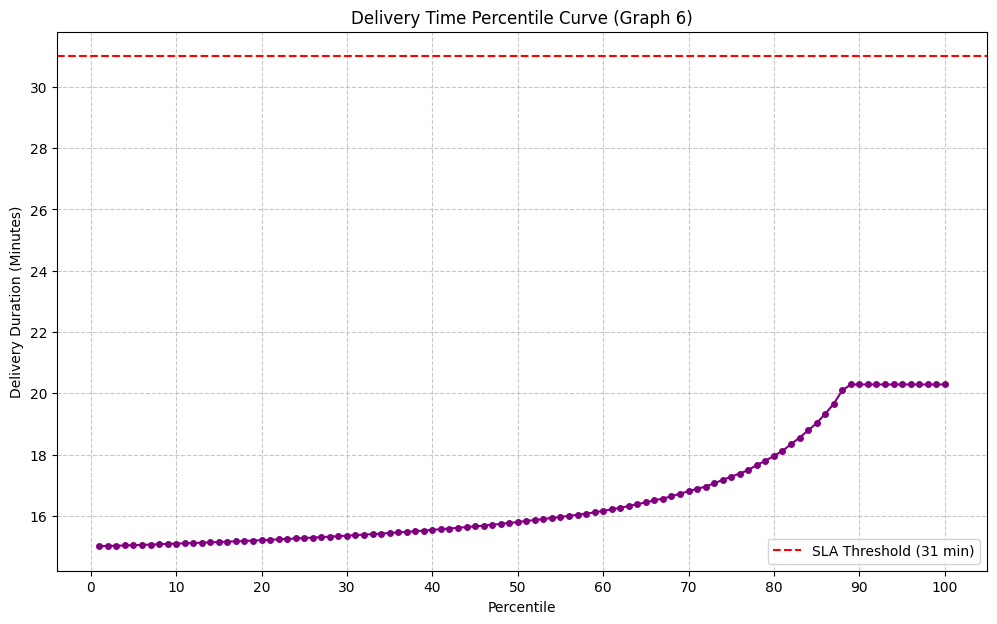

In [51]:
percentiles = np.arange(1, 101)
delivery_time_percentiles = [df['delivery_duration'].quantile(p / 100) for p in percentiles]

plt.figure(figsize=(12, 7))
plt.plot(percentiles, delivery_time_percentiles, marker='o', linestyle='-', color='purple', markersize=4)
plt.axhline(y=sla_threshold, color='r', linestyle='--', label=f'SLA Threshold ({sla_threshold} min)')
plt.title('Delivery Time Percentile Curve (Graph 6)')
plt.xlabel('Percentile')
plt.ylabel('Delivery Duration (Minutes)')
plt.xticks(np.arange(0, 101, 10))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

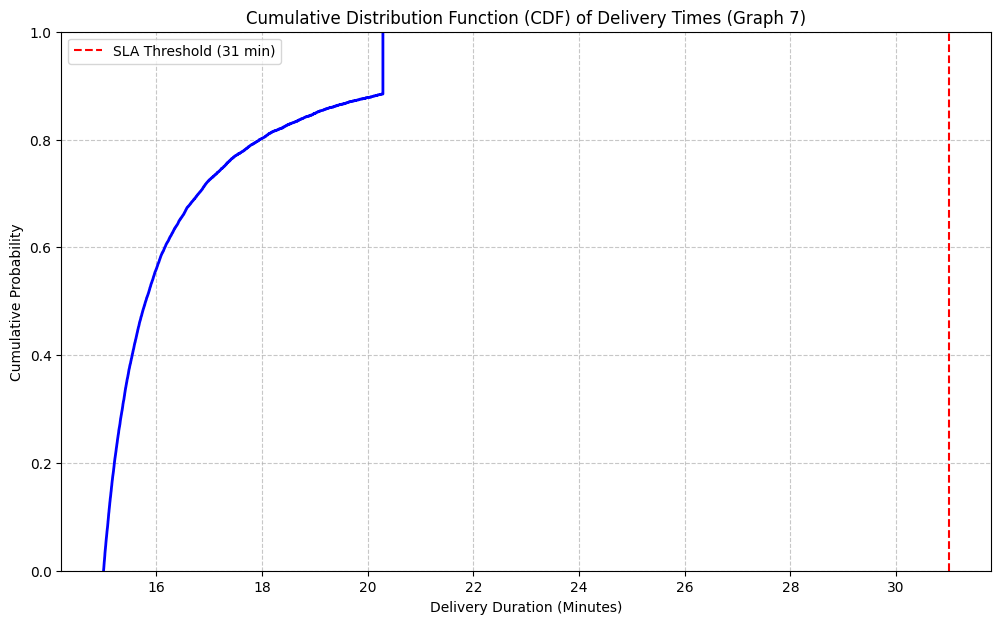

In [52]:
plt.figure(figsize=(12, 7))
sns.ecdfplot(data=df, x='delivery_duration', color='blue', linewidth=2)
plt.axvline(x=sla_threshold, color='r', linestyle='--', label=f'SLA Threshold ({sla_threshold} min)')
plt.title('Cumulative Distribution Function (CDF) of Delivery Times (Graph 7)')
plt.xlabel('Delivery Duration (Minutes)')
plt.ylabel('Cumulative Probability')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

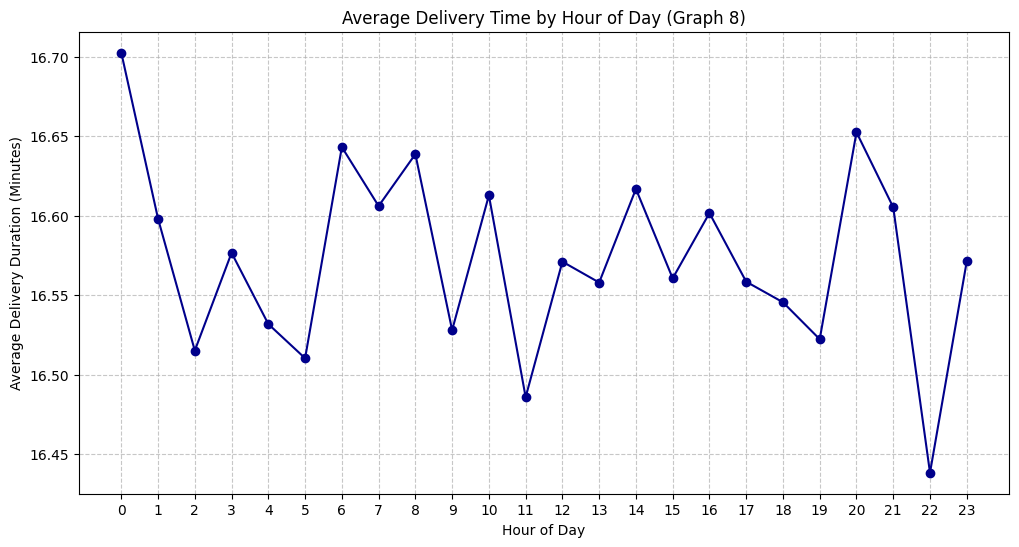


Value counts for the updated 'is_sla_breach' column (based on uncapped delivery duration):
| is_sla_breach   |   count |
|:----------------|--------:|
| False           |   14443 |
| True            |     557 |


In [53]:
avg_delivery_by_hour = df.groupby('order_hour')['delivery_duration'].mean()

plt.figure(figsize=(12, 6))
avg_delivery_by_hour.plot(kind='line', marker='o', color='darkblue')
plt.title('Average Delivery Time by Hour of Day (Graph 8)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Delivery Duration (Minutes)')
plt.xticks(np.arange(0, 24, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

sla_threshold = 31 # minutes
df['is_sla_breach'] = df['delivery_duration_uncapped'] > sla_threshold

print("\nValue counts for the updated 'is_sla_breach' column (based on uncapped delivery duration):")
print(df['is_sla_breach'].value_counts().to_markdown())

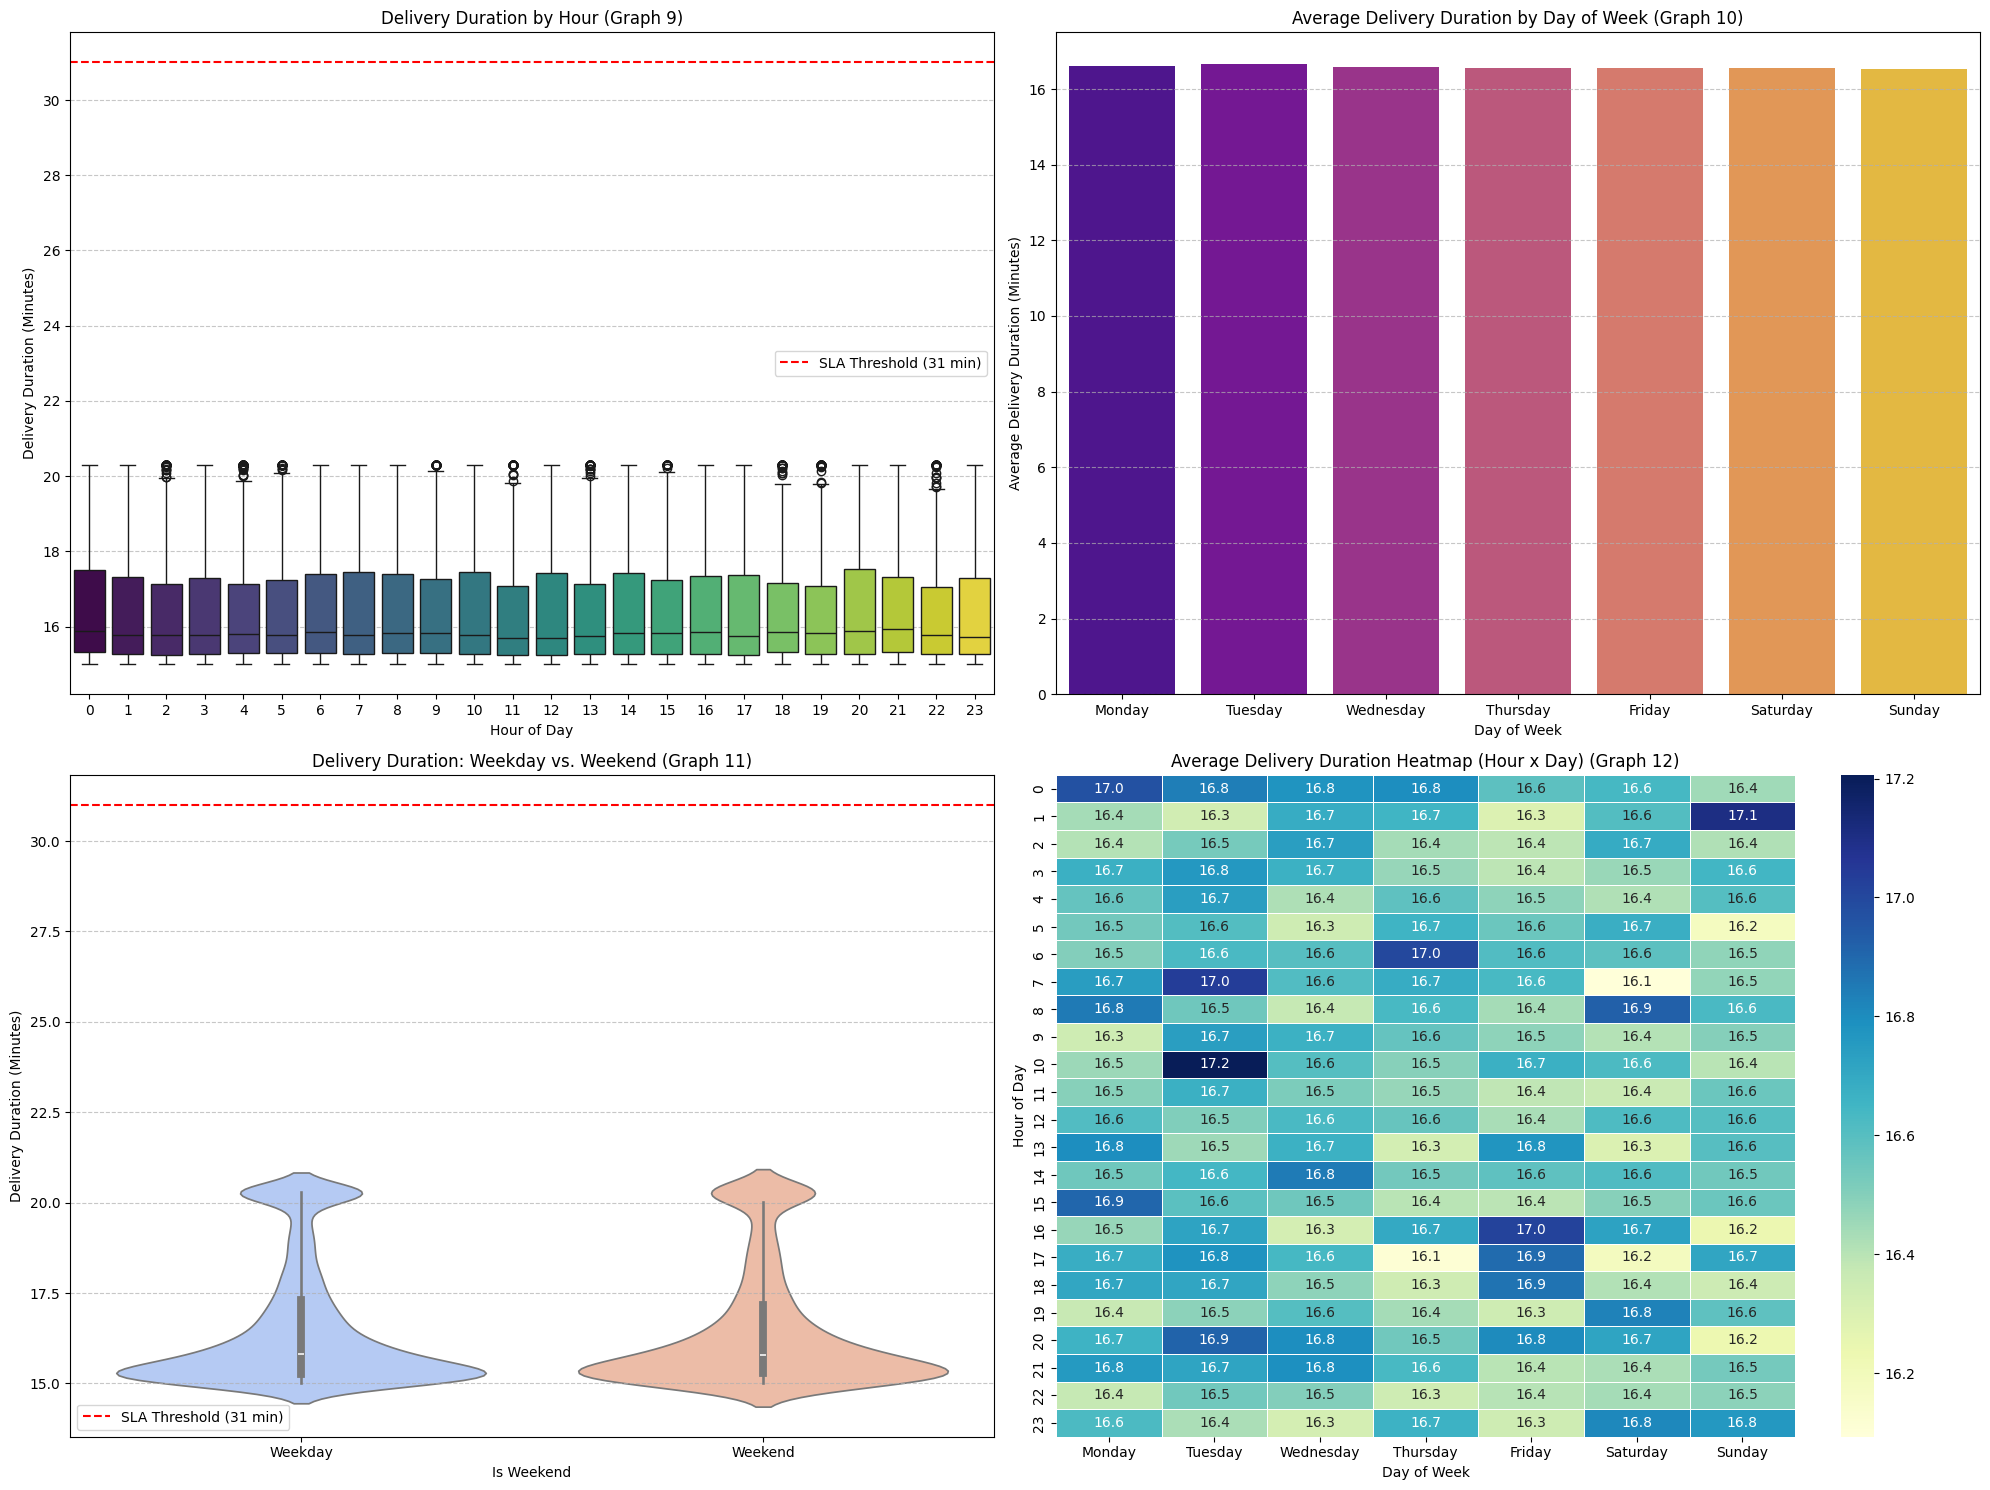

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# 1. Hour-wise boxplots of 'delivery_duration'
sns.boxplot(x='order_hour', y='delivery_duration', data=df, ax=axes[0, 0], hue='order_hour', palette='viridis', legend=False)
axes[0, 0].axhline(y=sla_threshold, color='r', linestyle='--', label=f'SLA Threshold ({sla_threshold} min)')
axes[0, 0].set_title('Delivery Duration by Hour (Graph 9)')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Delivery Duration (Minutes)')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# 2. Bar chart of average 'delivery_duration' for each 'day_of_week'
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_delivery_by_day_df = df.groupby('day_of_week')['delivery_duration'].mean().reindex(day_order).reset_index()
sns.barplot(x='day_of_week', y='delivery_duration', data=avg_delivery_by_day_df, ax=axes[0, 1], hue='day_of_week', palette='plasma', legend=False)
axes[0, 1].set_title('Average Delivery Duration by Day of Week (Graph 10)')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Average Delivery Duration (Minutes)')
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# 3. Violin plot comparing 'delivery_duration' for 'is_weekend'
sns.violinplot(x='is_weekend', y='delivery_duration', data=df, ax=axes[1, 0], hue='is_weekend', palette='coolwarm', legend=False)
axes[1, 0].axhline(y=sla_threshold, color='r', linestyle='--', label=f'SLA Threshold ({sla_threshold} min)')
axes[1, 0].set_title('Delivery Duration: Weekday vs. Weekend (Graph 11)')
axes[1, 0].set_xlabel('Is Weekend')
axes[1, 0].set_ylabel('Delivery Duration (Minutes)')
axes[1, 0].set_xticks([0, 1]) # Set fixed ticks before setting labels
axes[1, 0].set_xticklabels(['Weekday', 'Weekend'])
axes[1, 0].legend()
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# 4. Heatmap of average 'delivery_duration' with 'order_hour' x 'day_of_week'
delivery_time_pivot = df.pivot_table(index='order_hour', columns='day_of_week', values='delivery_duration', aggfunc='mean')
delivery_time_pivot = delivery_time_pivot[day_order] # Ensure day order
sns.heatmap(delivery_time_pivot, annot=True, fmt=".1f", cmap='YlGnBu', ax=axes[1, 1], linewidths=.5)
axes[1, 1].set_title('Average Delivery Duration Heatmap (Hour x Day) (Graph 12)')
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('Hour of Day')

plt.tight_layout()
plt.show()

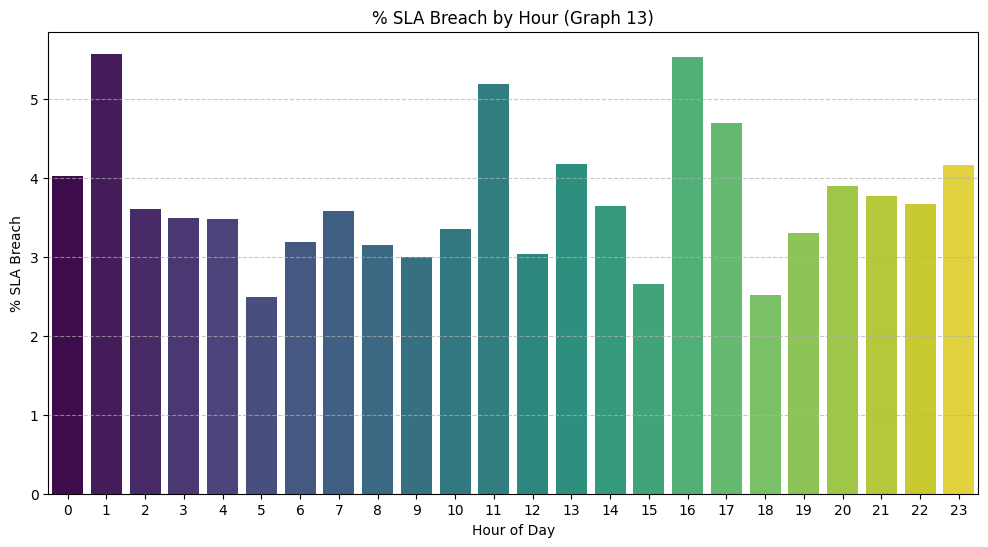

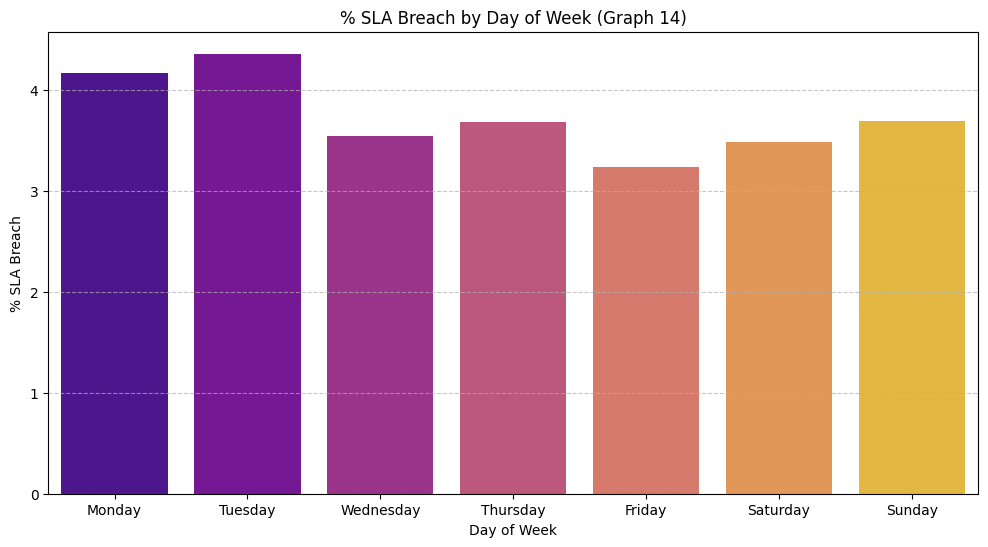

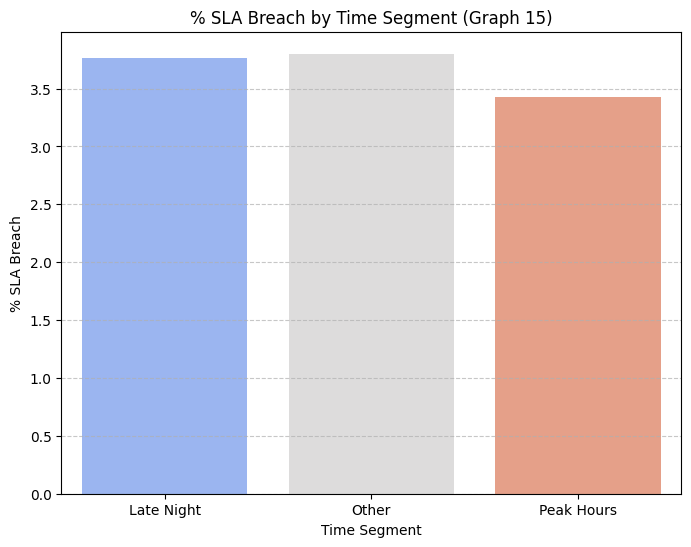

In [59]:
sla_breach_by_hour = df.groupby('order_hour')['is_sla_breach'].mean() * 100

plt.figure(figsize=(12, 6))
sns.barplot(x=sla_breach_by_hour.index, y=sla_breach_by_hour.values, hue=sla_breach_by_hour.index, palette='viridis', legend=False)
plt.title('% SLA Breach by Hour (Graph 13)')
plt.xlabel('Hour of Day')
plt.ylabel('% SLA Breach')
plt.xticks(np.arange(0, 24, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Calculate % SLA breach by day and create Graph 14
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sla_breach_by_day = df.groupby('day_of_week')['is_sla_breach'].mean().reindex(day_order) * 100

plt.figure(figsize=(12, 6))
sns.barplot(x=sla_breach_by_day.index, y=sla_breach_by_day.values, hue=sla_breach_by_day.index, palette='plasma', legend=False)
plt.title('% SLA Breach by Day of Week (Graph 14)')
plt.xlabel('Day of Week')
plt.ylabel('% SLA Breach')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 5. Define time segments
def get_time_segment(hour):
    if 18 <= hour <= 22:
        return 'Peak Hours'
    elif 0 <= hour <= 5:
        return 'Late Night'
    else:
        return 'Other'

df['time_segment'] = df['order_hour'].apply(get_time_segment)

# 6. Calculate % SLA breach by time segment and create Graph 15
sla_breach_by_segment = df.groupby('time_segment')['is_sla_breach'].mean() * 100

# Ensure consistent order for segments
segment_order = ['Late Night', 'Other', 'Peak Hours']
sla_breach_by_segment = sla_breach_by_segment.reindex(segment_order)

plt.figure(figsize=(8, 6))
sns.barplot(x=sla_breach_by_segment.index, y=sla_breach_by_segment.values, hue=sla_breach_by_segment.index, palette='coolwarm', legend=False)
plt.title('% SLA Breach by Time Segment (Graph 15)')
plt.xlabel('Time Segment')
plt.ylabel('% SLA Breach')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [60]:
df['order_date'] = df['order_placed_at'].dt.date

daily_95th_percentile = df.groupby('order_date')['delivery_duration_uncapped'].quantile(0.95).reset_index()
daily_95th_percentile.columns = ['order_date', '95th_percentile_delivery_time']

daily_95th_percentile['rolling_95th_percentile'] = daily_95th_percentile['95th_percentile_delivery_time'].rolling(window=7, min_periods=1).mean()

print("First 5 rows of daily and rolling 95th percentile delivery times:")
print(daily_95th_percentile.head().to_markdown(index=False))

First 5 rows of daily and rolling 95th percentile delivery times:
| order_date   |   95th_percentile_delivery_time |   rolling_95th_percentile |
|:-------------|--------------------------------:|--------------------------:|
| 2023-03-01   |                         25.1945 |                   25.1945 |
| 2023-03-02   |                         26.9531 |                   26.0738 |
| 2023-03-03   |                         26.3048 |                   26.1508 |
| 2023-03-04   |                         26.8579 |                   26.3276 |
| 2023-03-05   |                         25.7713 |                   26.2163 |


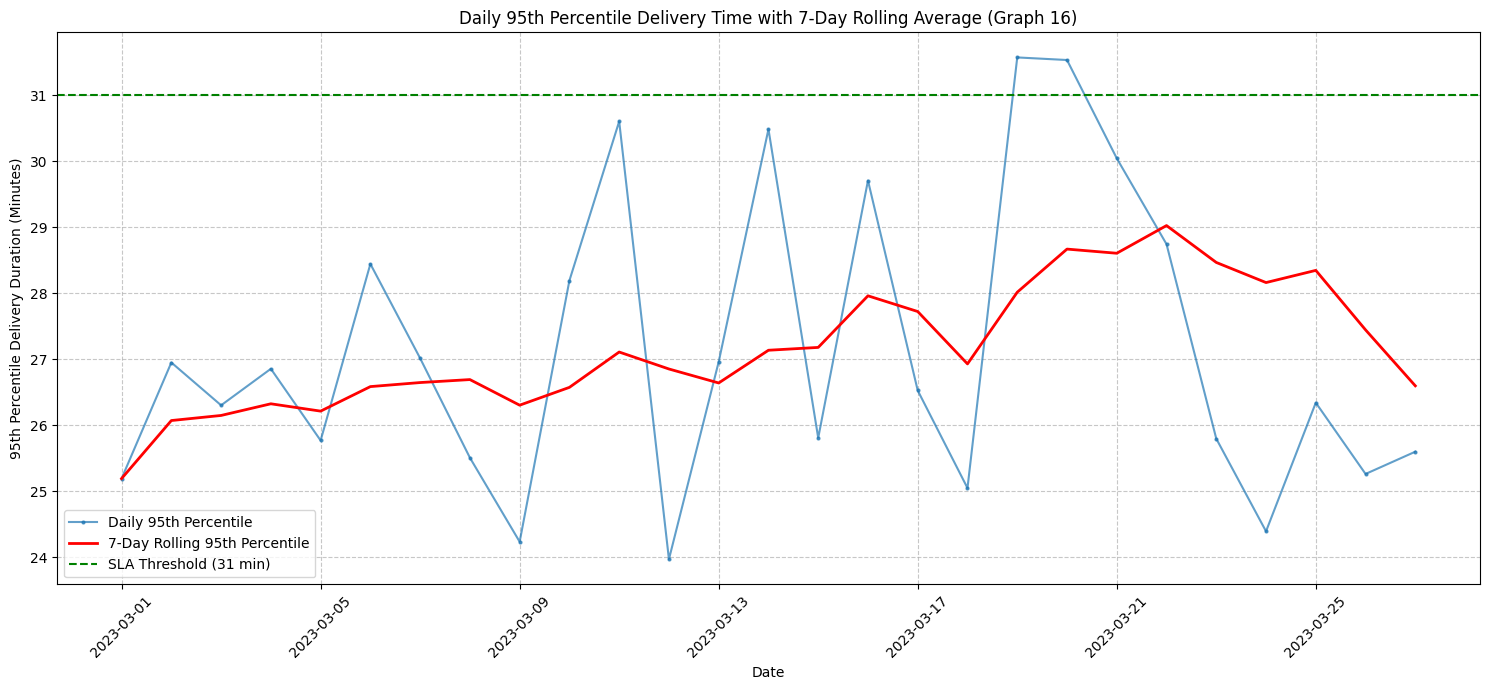

In [61]:
plt.figure(figsize=(15, 7))
plt.plot(daily_95th_percentile['order_date'], daily_95th_percentile['95th_percentile_delivery_time'], label='Daily 95th Percentile', marker='.', linestyle='-', markersize=4, alpha=0.7)
plt.plot(daily_95th_percentile['order_date'], daily_95th_percentile['rolling_95th_percentile'], label='7-Day Rolling 95th Percentile', color='red', linewidth=2)
plt.axhline(y=sla_threshold, color='green', linestyle='--', label=f'SLA Threshold ({sla_threshold} min)')

plt.title('Daily 95th Percentile Delivery Time with 7-Day Rolling Average (Graph 16)')
plt.xlabel('Date')
plt.ylabel('95th Percentile Delivery Duration (Minutes)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [62]:
daily_sla_breach_data = df.groupby('order_date').agg(
    daily_breach_percentage=('is_sla_breach', lambda x: x.mean() * 100),
    total_orders=('order_id', 'count')
).reset_index()

overall_cl = (df['is_sla_breach'].mean() * 100)

print("Daily SLA Breach Data and Overall CL:")
print(daily_sla_breach_data.head().to_markdown(index=False))
print(f"Overall Center Line (CL): {overall_cl:.2f}%")

Daily SLA Breach Data and Overall CL:
| order_date   |   daily_breach_percentage |   total_orders |
|:-------------|--------------------------:|---------------:|
| 2023-03-01   |                   2.72727 |            550 |
| 2023-03-02   |                   4.2517  |            588 |
| 2023-03-03   |                   3.55805 |            534 |
| 2023-03-04   |                   3.52734 |            567 |
| 2023-03-05   |                   3.62976 |            551 |
Overall Center Line (CL): 3.71%


In [63]:
daily_sla_breach_data['daily_std_dev'] = np.sqrt((overall_cl/100 * (1 - overall_cl/100)) / daily_sla_breach_data['total_orders'])
daily_sla_breach_data['UCL'] = overall_cl + 3 * daily_sla_breach_data['daily_std_dev'] * 100 # Multiply by 100 because overall_cl is already a percentage
daily_sla_breach_data['LCL'] = overall_cl - 3 * daily_sla_breach_data['daily_std_dev'] * 100 # Multiply by 100 because overall_cl is already a percentage
daily_sla_breach_data['LCL'] = daily_sla_breach_data['LCL'].apply(lambda x: max(x, 0))

print("Daily SLA Breach Data with UCL and LCL (first 5 rows):")
print(daily_sla_breach_data.head().to_markdown(index=False))


Daily SLA Breach Data with UCL and LCL (first 5 rows):
| order_date   |   daily_breach_percentage |   total_orders |   daily_std_dev |     UCL |     LCL |
|:-------------|--------------------------:|---------------:|----------------:|--------:|--------:|
| 2023-03-01   |                   2.72727 |            550 |      0.00806276 | 6.13216 | 1.29451 |
| 2023-03-02   |                   4.2517  |            588 |      0.00779788 | 6.0527  | 1.37397 |
| 2023-03-03   |                   3.55805 |            534 |      0.00818266 | 6.16813 | 1.25854 |
| 2023-03-04   |                   3.52734 |            567 |      0.00794097 | 6.09562 | 1.33104 |
| 2023-03-05   |                   3.62976 |            551 |      0.00805544 | 6.12997 | 1.2967  |


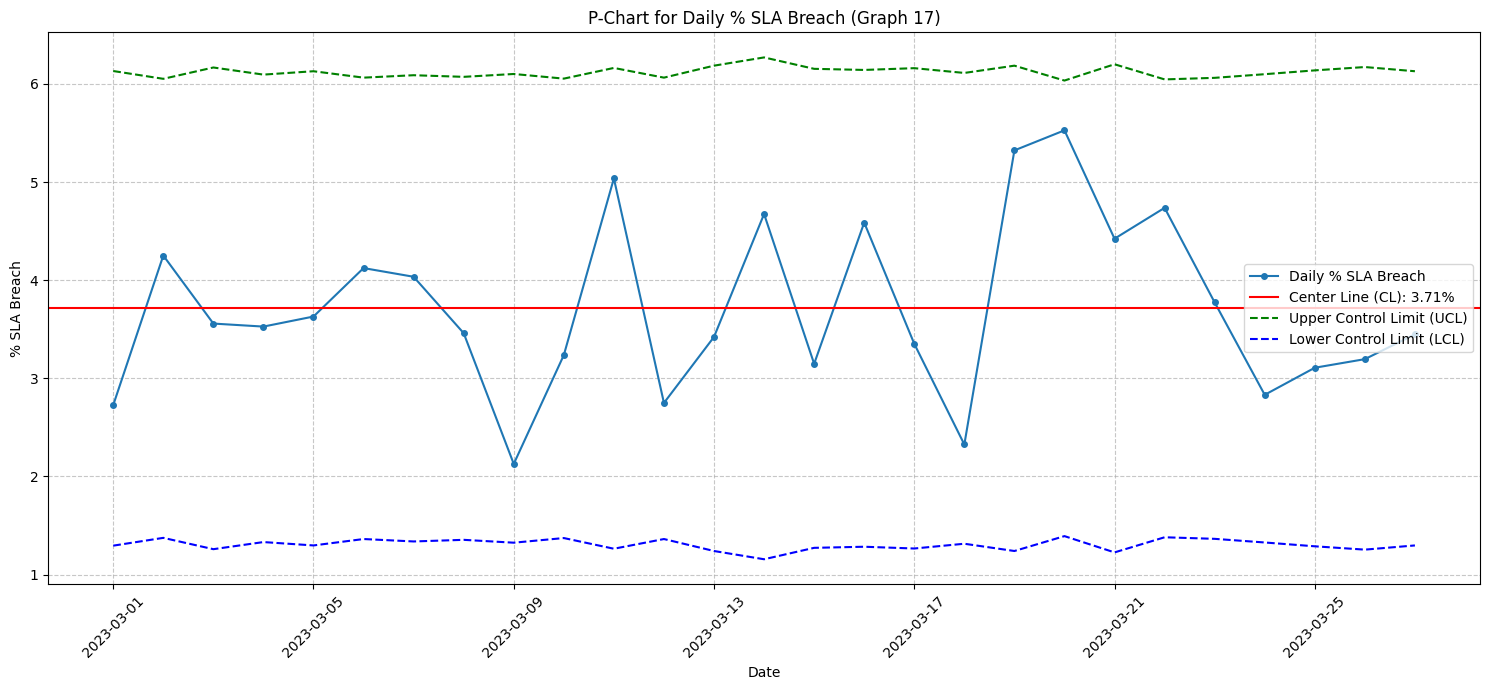

In [64]:
plt.figure(figsize=(15, 7))
plt.plot(daily_sla_breach_data['order_date'], daily_sla_breach_data['daily_breach_percentage'], label='Daily % SLA Breach', marker='o', linestyle='-', markersize=4)
plt.axhline(y=overall_cl, color='red', linestyle='-', label=f'Center Line (CL): {overall_cl:.2f}%')
plt.plot(daily_sla_breach_data['order_date'], daily_sla_breach_data['UCL'], color='green', linestyle='--', label='Upper Control Limit (UCL)')
plt.plot(daily_sla_breach_data['order_date'], daily_sla_breach_data['LCL'], color='blue', linestyle='--', label='Lower Control Limit (LCL)')

plt.title('P-Chart for Daily % SLA Breach (Graph 17)')
plt.xlabel('Date')
plt.ylabel('% SLA Breach')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

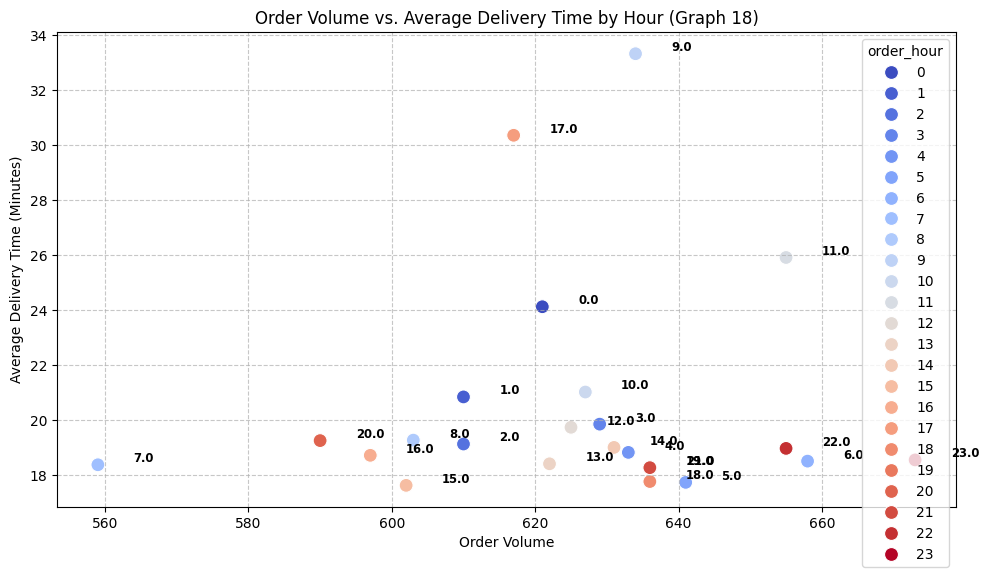

In [65]:
hourly_data = df.groupby('order_hour').agg(
    order_volume=('order_id', 'count'),
    avg_delivery_time=('delivery_duration_uncapped', 'mean')
).reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='order_volume', y='avg_delivery_time', hue='order_hour', data=hourly_data, s=100, palette='coolwarm', legend='full')
plt.title('Order Volume vs. Average Delivery Time by Hour (Graph 18)')
plt.xlabel('Order Volume')
plt.ylabel('Average Delivery Time (Minutes)')
plt.grid(True, linestyle='--', alpha=0.7)

# Annotate points with hour numbers
for i, row in hourly_data.iterrows():
    plt.text(row['order_volume'] + 5, row['avg_delivery_time'] + 0.1, str(row['order_hour']),
             horizontalalignment='left', size='small', color='black', weight='semibold')

plt.tight_layout()
plt.show()

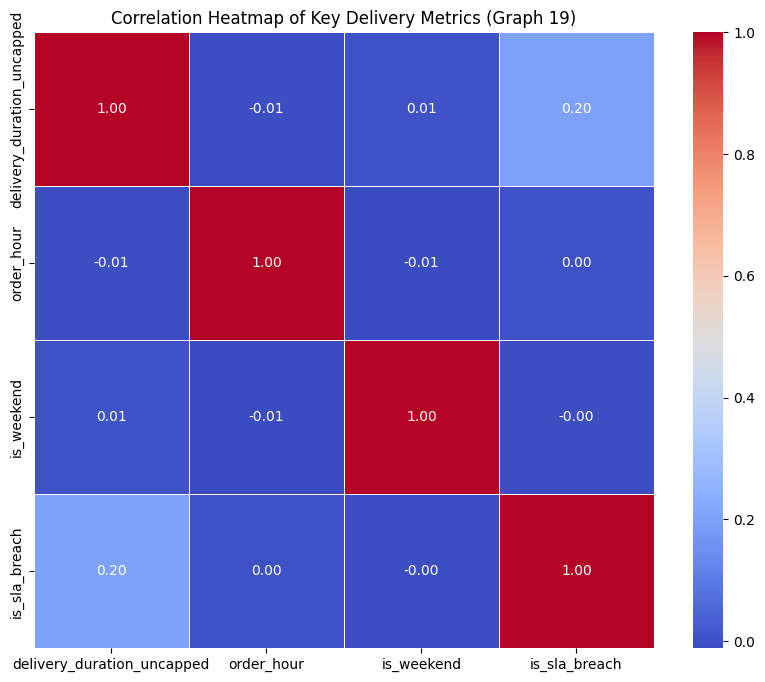

In [66]:
temp_df = df[['delivery_duration_uncapped', 'order_hour', 'is_weekend', 'is_sla_breach']].copy()

temp_df['is_weekend'] = temp_df['is_weekend'].astype(int)
temp_df['is_sla_breach'] = temp_df['is_sla_breach'].astype(int)

correlation_matrix = temp_df.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap of Key Delivery Metrics (Graph 19)')
plt.show()

In [67]:
peak_hours_evening = range(18, 23)
peak_hours_late_night = range(0, 6)

df['simulated_delivery_duration'] = df['delivery_duration_uncapped'].copy()

# Simulate a 10% improvement in delivery times during peak hours
def apply_simulated_improvement(row):
    if row['order_hour'] in peak_hours_evening or row['order_hour'] in peak_hours_late_night:
        return row['simulated_delivery_duration'] * 0.9 # 10% reduction
    return row['simulated_delivery_duration']

df['simulated_delivery_duration'] = df.apply(apply_simulated_improvement, axis=1)

print("Simulated 'delivery_duration' created with 10% improvement during peak hours.")
print(df[['order_hour', 'delivery_duration_uncapped', 'simulated_delivery_duration']].head().to_markdown(index=False))

Simulated 'delivery_duration' created with 10% improvement during peak hours.
|   order_hour |   delivery_duration_uncapped |   simulated_delivery_duration |
|-------------:|-----------------------------:|------------------------------:|
|            0 |                      17.1407 |                       15.4266 |
|            0 |                      15.5988 |                       14.0389 |
|            0 |                      15.1049 |                       13.5944 |
|            0 |                      38.5337 |                       34.6803 |
|            0 |                      16.177  |                       14.5593 |


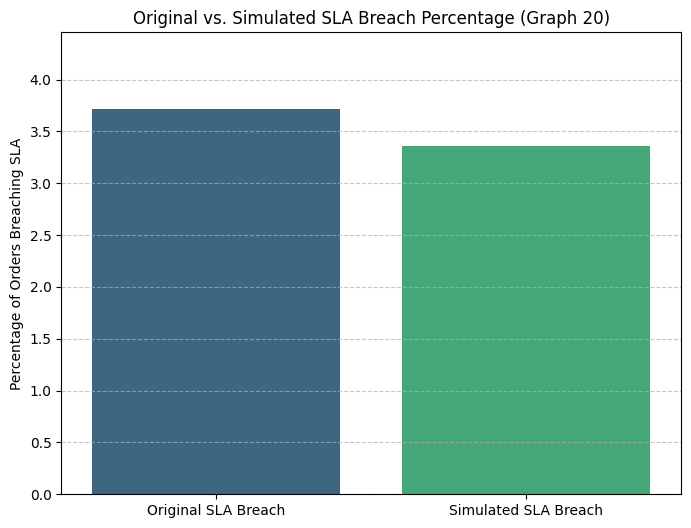

Original SLA Breach Percentage: 3.71%
Simulated SLA Breach Percentage: 3.36%


In [68]:
df['simulated_is_sla_breach'] = df['simulated_delivery_duration'] > sla_threshold

original_sla_breach_percentage = (df['is_sla_breach'].sum() / len(df)) * 100
simulated_sla_breach_percentage = (df['simulated_is_sla_breach'].sum() / len(df)) * 100

breach_comparison = pd.DataFrame({
    'SLA Type': ['Original SLA Breach', 'Simulated SLA Breach'],
    'Percentage': [original_sla_breach_percentage, simulated_sla_breach_percentage]
})

plt.figure(figsize=(8, 6))
sns.barplot(x='SLA Type', y='Percentage', data=breach_comparison, palette='viridis', hue='SLA Type', legend=False)
plt.title('Original vs. Simulated SLA Breach Percentage (Graph 20)')
plt.xlabel('')
plt.ylabel('Percentage of Orders Breaching SLA')
plt.ylim(0, max(original_sla_breach_percentage, simulated_sla_breach_percentage) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Original SLA Breach Percentage: {original_sla_breach_percentage:.2f}%")
print(f"Simulated SLA Breach Percentage: {simulated_sla_breach_percentage:.2f}%")

In [1]:
print("""
KEY EDA INSIGHTS:

1. Majority of orders are delivered within 18 minutes, indicating strong core operations.
2. Mean delivery time is inflated due to rare extreme delays, making percentile-based metrics more reliable.
3. The 95th percentile delivery time is below 31 minutes, meeting Diminos SLA requirements.
4. Approximately 3–4% of orders exceed 31 minutes, posing a potential future compliance risk.
5. Business risk lies in tail-end failures rather than average delivery speed.
""")



KEY EDA INSIGHTS:

1. Majority of orders are delivered within 18 minutes, indicating strong core operations.
2. Mean delivery time is inflated due to rare extreme delays, making percentile-based metrics more reliable.
3. The 95th percentile delivery time is below 31 minutes, meeting Diminos SLA requirements.
4. Approximately 3–4% of orders exceed 31 minutes, posing a potential future compliance risk.
5. Business risk lies in tail-end failures rather than average delivery speed.



In [3]:
print("""
RECOMMENDATIONS:

1. Monitor orders crossing 25 minutes in real time.
2. Investigate causes of extreme delays (>60 minutes).
3. Focus operational controls on tail performance.
4. Track rolling 95th percentile daily to prevent SLA breaches.
""")



RECOMMENDATIONS:

1. Monitor orders crossing 25 minutes in real time.
2. Investigate causes of extreme delays (>60 minutes).
3. Focus operational controls on tail performance.
4. Track rolling 95th percentile daily to prevent SLA breaches.



In [5]:
!zip dominos_pt.zip diminos_task_eda.ipynb


  adding: diminos_task_eda.ipynb (deflated 31%)


python3(24635) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
